# 1. Import required packages

In [1]:
import fine as fn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import csv
import numpy as np
from matplotlib.gridspec import GridSpec
import seaborn as sns
from PIL import Image
import matplotlib.image as mpimg
from pathlib import Path
import os
import warnings
from matplotlib.ticker import FuncFormatter

cwd = Path.cwd()

np.random.seed(
    42
)  # Sets a "seed" to produce the same random input data in each model run

Einlesen der pd.Series aus inputs.ipynb

In [2]:
stromverbr = pd.read_pickle("stromverbrauch.pkl")
heizungswasserverb = pd.read_pickle("heizungswasser.pkl")
strompreis_cost = pd.read_pickle("strompreis_cost.pkl")
strompreis_revenue = pd.read_pickle("strompreis_revenue.pkl")
strompreis_cost_sinkt = pd.read_pickle("strompreis_cost_sinkt.pkl")
strompreis_revenue_sinkt = pd.read_pickle("strompreis_revenue_sinkt.pkl")
strompreis_cost_steigt = pd.read_pickle("strompreis_cost_steigt.pkl")
strompreis_revenue_steigt = pd.read_pickle("strompreis_revenue_steigt.pkl")
strompreis_cost_schwankt = pd.read_pickle("strompreis_cost_schwankt.pkl")
strompreis_revenue_schwankt = pd.read_pickle("strompreis_revenue_schwankt.pkl")
stromemissionen = pd.read_pickle("stromemissionen.pkl")
gaspreis = pd.read_pickle("gaspreis.pkl")
gaspreis_sensi = pd.read_pickle("gaspreisSensi.pkl")
pv = pd.read_pickle("pv.pkl")
cop = pd.read_pickle("cop.pkl")

In [3]:
df_strom_pr_em_2023 = pd.read_pickle("StromPreisEmissionen.pkl") # €/MWh
df_strom_pr_em_2023_sensi = pd.read_pickle("StromPreisEmissionenSensi.pkl")

Für die Sensitivitätsanalyse der CO2-Intensität des Stroms

In [6]:
stromemissionen.mean()

367.2723005136986

In [115]:
stromemissionen=0.143*stromemissionen

In [116]:
stromemissionen.mean()

52.519938973458906

# 2. Create an energy system model instance

In [7]:
# Input parameters
locations = {"FabrikAachen"}
commodityUnitDict = {
    "strom": r"kW_el", # sinnvolle Maßeinheiten pro Stunde
    "netzstrom": r"kW_el",
    "erdgas": r"kW_CH4,LHV",
    "CO2": r"gCO2/h",
    "heizungswasser": r"kW_th",
}
commodities = {"strom", "netzstrom", "erdgas", "CO2", "heizungswasser"}
numberOfTimeSteps, hoursPerTimeStep = 8760, 1 # Index geht von 0 bis 8759
costUnit, lengthUnit = "Euro", "m" # 1e3  wären 1000
startYear = 2023

# Code
esM = fn.EnergySystemModel(
    locations=locations,
    commodities=commodities,
    numberOfTimeSteps=numberOfTimeSteps,
    commodityUnitsDict=commodityUnitDict,
    hoursPerTimeStep=hoursPerTimeStep,
    costUnit=costUnit,
    lengthUnit=lengthUnit,
    verboseLogLevel=0,
    startYear=startYear,
)

In [8]:
esM.componentNames

{}

# 3. Add commodity sources to the energy system model

## 3.1 Electricity source
### PV (Brown Field)

bei Basisszeanrio: capacityFix=2000

bei SensAnly: capacityMax

In [9]:
esM.add(
    fn.Source(
        esM=esM,
        name="PV",
        commodity="strom",
        hasCapacityVariable=True,
        # capacityVariableDomain wird als continuous angenommen
        operationRateFix=pv,
        capacityFix=2000, # kW
        #capacityMax=4000,
        investPerCapacity=947.10, # €/kW
        opexPerCapacity=947.10 * 0.01, # €/kW
        interestRate=0.05,
        economicLifetime=20, # a
        # yearlyFullLoadHoursMin bzw. Max ist bei gegebener operationRateMax und capacity nicht wichtig
        # commodityRevenue=0.1047 # €/kWh
    )
)

### Netzstrom (Brownfield)

für Sensitivitätsanalyse ändern

In [10]:
esM.add(
    fn.Source(
        esM=esM,
        name="Stromkauf von Spotmarkt",
        commodity="netzstrom",
        hasCapacityVariable=False,
        commodityCostTimeSeries=strompreis_cost, # €/kWh
        commodityRevenueTimeSeries=strompreis_revenue # €/kWh
    )
)

## 3.2 Gas (Brownfield)

bei Sensitivitätsanalyse commodityCost ändern

In [11]:
esM.add(
    fn.Source(
        esM=esM,
        name="Erdgaskauf",
        commodity="erdgas",
        hasCapacityVariable=False,
        commodityCostTimeSeries=gaspreis # €/kWh
        #commodityCost=0.0336
    )
)

# 4. Add conversion components to the energy system model

## 4.1 Stromnetzanschluss (Brownfield)

In [12]:
esM.add(
    fn.Conversion(
        esM=esM,
        name="Netzanschluss",
        physicalUnit=r"kW_el",
        commodityConversionFactors={
            "netzstrom": -1,
            "strom": 1,
            "CO2": stromemissionen, # g/kWh
        },
        hasCapacityVariable=False,
    )
)

## 4.2 BHKW (Brownfield)

In [13]:
co2_faktor_gas = 200.8

capacityMax nicht capacityFix, weil wir Kälte und Dampf nicht berücksichtigen

In [14]:
esM.add(
    fn.Conversion(
        esM=esM,
        name="BHKW",
        physicalUnit=r"kW_el", # d. h., so skalieren, dass commodityConversionFactors für "strom": 1
        commodityConversionFactors={
            "strom": 0.4225 / 0.4225, # nach eigenen Berechnungen, mit Ausreißerbereinigung
            "heizungswasser": 0.4113 / 0.4225, # inkl. heisswasser # nach eigenen Berechnungen, mit Ausreißerbereinigung
            "erdgas": -1 / 0.4225,
            "CO2": co2_faktor_gas / 0.4225, # g/kWh_Primärenergie, nach Quasching, wie Jin et. al. // FfE: 50 bis zu 100 g/kWh_el...dort sehr verschiedene Allokationsmethoden // 2017er Paper: 50-100, 200-280
        },
        hasCapacityVariable=True,
        capacityMax=1.99*1000, # Elektrische Nennleistung von 1,99 MW_el, durchschnittliche Leistung von 1,0 (bis April 1,66) MW_el
        interestRate=0.05,
        economicLifetime=20-10, # remainingEconomicLifetime 10a # default 10
        investPerCapacity=0, # wird in den nächsten Jahren abgeschrieben, 800€/kW_el
        opexPerCapacity=800*0.02, # 16€/kW_el
        opexPerOperation=0.008, # €/kWh_el
        # yearlyFullLoadHoursMin?
    )
)

# 5. Add commodity storages to the energy system model

## 5.1 Pufferspeichergröße berechnen

In [ ]:
capacity_kw = 1990
efficiency = 0.4113 / 0.4225
hours_in_year = 8760

index = range(0, hours_in_year)
generation_series_wärme = pd.Series([capacity_kw * efficiency] * len(index), index=index)
differenz_wärme_erzeugung_bedarf = generation_series_wärme - heizungswasserverb
print(f"Stunden mit zu wenig BHKW-Erzeugung {(differenz_wärme_erzeugung_bedarf <= 0).sum()}")
print(f"Minimum der Differenz {differenz_wärme_erzeugung_bedarf.min()} --> für Dimensionierung Wasserspeicher ")
print(f"Welcher Teil des Wärmebedarfs kann nie aus BHKW direkt gedeckt werden? {(abs(differenz_wärme_erzeugung_bedarf[differenz_wärme_erzeugung_bedarf < 0]).sum()/heizungswasserverb.sum())}")
print(f"Welcher Wärmebedarf kann nie aus BHKW direkt gedeckt werden? {abs(differenz_wärme_erzeugung_bedarf[differenz_wärme_erzeugung_bedarf < 0]).sum()}")
# der Überschuss ist Prozessdmapf+Kälte
plt.plot(differenz_wärme_erzeugung_bedarf, linewidth=0.5)
plt.ylabel("kW")
plt.xlabel("Stunden in 2023")
#plt.title("BHKW-Erzeugung - Wärmebedarf")
plt.show()

Dimensionierung Überschuss

In [ ]:
differenz_wärme_erzeugung_bedarf.max()

## 5.2 Pufferspeicherobjekt

In [15]:
esM.add(
    fn.Storage(
        esM=esM,
        name="Heizungswasserspeicher",
        commodity="heizungswasser",
        chargeRate=1.0,
        dischargeRate=1.0,
        chargeEfficiency=1,
        dischargeEfficiency=1,
        selfDischarge=0,
        hasCapacityVariable=True,
        interestRate=0.05,
        economicLifetime=30,
        investPerCapacity=0, # €/kWh
        opexPerCapacity=0, # €/kWh
        hasIsBuiltBinaryVariable=True,
        bigM=1000
    )
)

# 6. Add commodity transmission components to the energy system

Die Gebäude werden aggregiert als ein Unternehmensstandort betrachtet. (Die Kapazität der Leitungen wird als unendlich groß angenommen, sodass es keine Limitationen gibt.)

# 7. Add commodity sinks to the energy system model

## 7.1 Electricity Demand

In [16]:
esM.add(
    fn.Sink(
        esM=esM,
        name="Strombedarf",
        commodity="strom",
        hasCapacityVariable=False,
        operationRateFix=stromverbr, # kWh
    )
)

## 7.2 Heat Demand Low Temperature / Heizungswasser Gebäude 201+301+401 sowie das Heißwasser, was zum Raum heizen verwendet wird

In [17]:
esM.add(
    fn.Sink(
        esM=esM,
        name="Heizungswasserbedarf",
        commodity="heizungswasser",
        hasCapacityVariable=False,
        operationRateFix=heizungswasserverb, # kWh
    )
)

## 7.3 CO2

In [18]:
esM.add(
    fn.Sink(
        esM=esM,
        name="CO2 in Atmosphäre",
        commodity="CO2",
        hasCapacityVariable=False,
        commodityLimitID="CO2 limit",
        yearlyLimit= 9999 * 1000 * 1000, # erste Zahl in t denken und dann umrechnen in g
        #yearlyLimit=5004938271.6049385,
        commodityCost=30/(1000*1000), # 30 €/t CO2-Preis
    )
)

## 7.4 Stromüberschuss

### 7.4.1 Stromüberschüss berechnen

Text(0, 0.5, 'Leistung in kW')

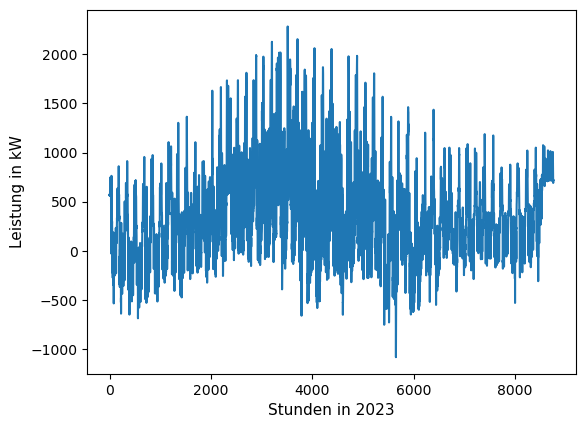

In [ ]:
capacity_kw = 1990
efficiency = 0.4225/0.4225
hours_in_year = 8760

index = range(0, hours_in_year)
generation_series = pd.Series([capacity_kw * efficiency] * len(index), index=index)
stromüberschuss = generation_series + pv*2000 - stromverbr
plt.figure(figsize=(16/2.54, 12/2.54))
plt.plot(stromüberschuss)
plt.xlabel("Stunden in 2023", fontsize=11)
plt.ylabel("Leistung in kW", fontsize=11)

In [27]:
cd = r"C:\Users\Administrator\Nextcloud\MA_Aicha Platzdasch\Input_Grünenthal\2_Daten"
path = os.path.join(cd, "240731_Energiedaten_2023_Komplett.xlsx")
path_bhkw = os.path.join(cd, "240731_Energiedaten_307_2023.xlsx")
path_strom_pr_em = os.path.join(cd, "231231StromPreisEmissionsfaktorAgora.csv")

excel mit fast allen verbräuchen

In [28]:
# Suppress the warning about the default style
warnings.simplefilter(action='ignore', category=UserWarning)

df = pd.read_excel(path)
df.set_index('Datum', inplace=True)
df.index = pd.to_datetime(df.index, format='%d.%m.%Y  %H:%M')

# df_2023 = df[df.index.year == 2023] # diesen Filter nicht mehr, da in der Excel nur 2023er Daten drin sind, aber der "Bis-Zeitstempel" also ab 1.1.23 1 Uhr bis 1.1.24 0 Uhr
df_2023 = df

df_2023.reset_index(drop=True, inplace=True)
df_2023.index = df_2023.index + 0 # macht Index ab 0, ... + 1 macht Index ab 1

# Zahlenformat 1000,00 bereits richtig konvertiert in 1000.00

In [29]:
stromeinspeisung_real = df_2023["Stromzähler W5 20kV-Ausspeisung Kaubendenstr. (Geb. 809) - ∅ - kW"]
print(stromeinspeisung_real.sum())
print((pv*2000).sum())
print(stromeinspeisung_real.max())

72400.15
2239000.0
306.41


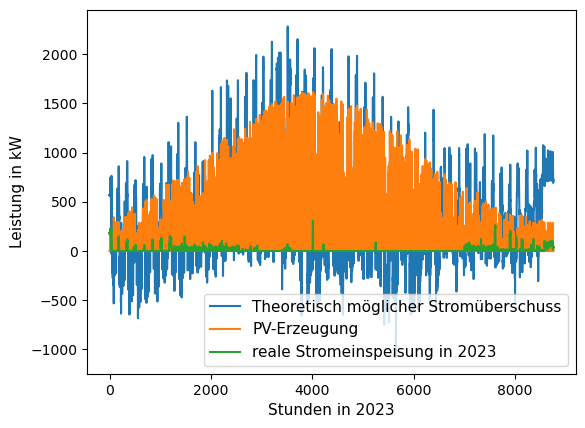

In [ ]:
plt.figure(figsize=(16/2.54, 12/2.54))
plt.plot(stromüberschuss, label="Theoretisch möglicher Stromüberschuss")
plt.plot(pv*2000, label="PV-Erzeugung")
plt.plot(stromeinspeisung_real, label="reale Stromeinspeisung in 2023")
plt.xlabel("Stunden in 2023", fontsize=11)
plt.ylabel("Leistung in kW", fontsize=11)
plt.legend(fontsize=11)

größtmöglicher Stromüberschuss wird angenommen, gigantisch überschätzt. 
damit Stromkauf zu negativen Preisen und Wiedereinspeisung vermieden wird, gibt es die costTS

## 7.4.2 Stromüberschussobjekt

In [20]:
stromüberschuss = np.clip(stromüberschuss, 0, None)
esM.add(
    fn.Sink(
        esM=esM,
        name="Überschussstrom in Netz",
        commodity="strom",
        hasCapacityVariable=False,
        operationRateMax=stromüberschuss,
        commodityCostTimeSeries=strompreis_revenue,
        #operationRateMax= pd.Series([2300] * len(index), index=index),
    )
)

# 8. Optimize energy system model

In [21]:
esM.componentNames

{'PV': 'SourceSinkModel',
 'Stromkauf von Spotmarkt': 'SourceSinkModel',
 'Erdgaskauf': 'SourceSinkModel',
 'Netzanschluss': 'ConversionModel',
 'BHKW': 'ConversionModel',
 'Heizungswasserspeicher': 'StorageModel',
 'Strombedarf': 'SourceSinkModel',
 'Heizungswasserbedarf': 'SourceSinkModel',
 'CO2 in Atmosphäre': 'SourceSinkModel',
 'Überschussstrom in Netz': 'SourceSinkModel'}

All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, the time series data of the specified components can be clustered before the optimization and the parameter timeSeriesAggregation is set to True in the optimize call.

In [ ]:
# esM.aggregateTemporally(numberOfTypicalPeriods=365)

In [22]:
timeSeriesAggregation=False
solver="gurobi"

In [23]:
esM.optimize(timeSeriesAggregation=timeSeriesAggregation, solver=solver)

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(3.1789 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.8757 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(1.5249 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring linked component quantity constraint...
		(0.0000 sec)

Declaring commodity balances...
		(3.4859 sec)

		(0.0000 sec)

Declaring objective function...
		(24.2112 sec)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-13
Read LP format model from file C:\Users\ADMINI~1\AppData\Local\Temp\tmp3cpfzlk4.pyomo.lp
Reading time = 0.47 seconds
x1: 105134 rows, 105134 columns, 275951 nonzeros
Set parameter QCPDual to value 1
Set parameter Threads to va

c:\Users\Administrator\anaconda3\envs\fine\Lib\site-packages\fine\component.py:4015: UserWarning: the capacity of component Heizungswasserspeicher is in one or more locations close or equal to the chosen Big M. Consider rerunning the simulation with a higher Big M.
  warnings.warn(
c:\Users\Administrator\anaconda3\envs\fine\Lib\site-packages\fine\storage.py:1984: UserWarning: Charge and discharge at the same time for component Heizungswasserspeicher
  warnings.warn(


for StorageModel ...  (1.6042sec)
		(17.9187 sec)



Gasbezug in real 2023 ist doppelt so hoch, aber hier wird auch Kälte und Proesswärme nicht berücksichtigt

Gasbezug real berechnen über ausreißerbereinigte (process_outliers_000) Zeitreihe df_bhkw_2023["Gasverbrauch Geb. 307 BHKW - ∅ - kW"] in inputs

Gasbezug real 24,8 GWh

Modell kauft 3 GWh mehr Strom

Stromkauf real berechnen über df_2023["Stromzähler W5 20kV-Einspeisung Kaubendenstr. (Geb. 809) - ∅ - kW"] in inputs

Stromkauf real 6 GWh

Dafür werden nur 51 statt 72 MWh eingespeist zurück ins Netz

In [24]:
srcSnkSummary = esM.getOptimizationSummary("SourceSinkModel",  ip=2023, outputLevel=1)
display(esM.getOptimizationSummary("SourceSinkModel", ip=2023, outputLevel=2))
tac_srcsnk = srcSnkSummary.xs('TAC', level='Property').sum().sum()
co2_srcsnk = srcSnkSummary.xs(('operation', '[gCO2/h*h/a]'), level=('Property', 'Unit')).loc['CO2 in Atmosphäre'].sum()
display(tac_srcsnk)
display(co2_srcsnk)

FabrikAachen
Component               Property        Unit                               
CO2 in Atmosphäre       NPVcontribution [Euro]                179870.275055
                        TAC             [Euro/a]              179870.275055
                        commodCosts     [Euro/a]              179870.275055
                        operation       [gCO2/h*h/a]      5995675835.158384
                                        [gCO2/h*h]        5995675835.158384
Erdgaskauf              NPVcontribution [Euro]                972414.958362
                        TAC             [Euro/a]              972414.958362
                        commodCosts     [Euro/a]              972414.958362
                        operation       [kW_CH4,LHV*h/a]     11477309.74147
                                        [kW_CH4,LHV*h]       11477309.74147
Heizungswasserbedarf    operation       [kW_th*h/a]          4720617.496667
                                        [kW_th*h]            4720617.496667
PV                      NPVcontribution [Euro]                170937.508657
                        TAC             [Euro/a]              170937.508657
                        capacity        [kW_el]                      2000.0
                        capexCap        [Euro/a]              151995.508657
                        commissioning   [kW_el]                      2000.0
                        invest          [Euro]                    1894200.0
                        operation       [kW_el*h/a]               2239000.0
                                        [kW_el*h]                 2239000.0
                        opexCap         [Euro/a]                    18942.0
Strombedarf             operation       [kW_el*h/a]            16662605.235
                                        [kW_el*h]              16662605.235
Stromkauf von Spotmarkt NPVcontribution [Euro]                952029.584525
                        TAC             [Euro/a]              952029.584525
                        commodCosts     [Euro/a]              953206.279302
                        commodRevenues  [Euro/a]                1176.694777
                        operation       [kW_el*h/a]          9625470.018913
                                        [kW_el*h]            9625470.018913
Überschussstrom in Netz NPVcontribution [Euro]                   285.831961
                        TAC             [Euro/a]                 285.831961
                        commodCosts     [Euro/a]                 285.831961
                        operation       [kW_el*h/a]            51028.149684
                                        [kW_el*h]              51028.149684

2275538.1585594066

5995675835.158384

In [25]:
convSummary = esM.getOptimizationSummary("ConversionModel", ip=2023, outputLevel=1)
tac_conv = convSummary.xs('TAC', level='Property').sum().sum()
display(esM.getOptimizationSummary("ConversionModel", ip=2023, outputLevel=2))
display(tac_conv)

FabrikAachen
Component     Property        Unit                       
BHKW          NPVcontribution [Euro]         69344.628103
              TAC             [Euro/a]       69344.628103
              capacity        [kW_el]         1909.457574
              commissioning   [kW_el]         1909.457574
              operation       [kW_el*h/a]  4849163.365771
                              [kW_el*h]    4849163.365771
              opexCap         [Euro/a]       30551.321177
              opexOp          [Euro/a]       38793.306926
Netzanschluss operation       [kW_el*h/a]  9625470.018913
                              [kW_el*h]    9625470.018913

69344.62810292523

In [26]:
storSummary = esM.getOptimizationSummary("StorageModel", ip=2023, outputLevel=1)
tac_stor = storSummary.xs('TAC', level='Property').sum().sum()
display(esM.getOptimizationSummary("StorageModel", ip=2023, outputLevel=2))
display(tac_stor)

FabrikAachen
Component              Property           Unit                       
Heizungswasserspeicher capacity           [kW_th*h]            1000.0
                       commissioning      [kW_th*h]            1000.0
                       isBuilt            [-]                     1.0
                       operationCharge    [kW_th*h/a]  4591530.630751
                                          [kW_th*h]    4591530.630751
                       operationDischarge [kW_th*h/a]  4591530.630751
                                          [kW_th*h]    4591530.630751

0.0

In [27]:
tac_total = tac_stor + tac_conv + tac_srcsnk
display(tac_total)

2344882.786662332

# 9. Visualisierungen

In [5]:
color_strom = (0/255, 83/255, 116/255)  # RGB (0, 83, 116)
color_raumwaerme = (176/255, 0/255, 70/255)  # RGB (176, 0, 70)
color_raumwaerme_light = (215/255, 127/255, 162/255)
color_strom_light = (140/255, 198/255, 221/255)
gelb_pv = (255/255, 205/255, 0/255)
rot_raumwaerme = color_raumwaerme
blau_stromkauf = (0/255, 128/255, 180/255)
dunkelblau_strom = color_strom
grün_tes = (0/255, 113/255, 86/255)
lila_gas = (118/255, 0/255, 118/255)
weinrot_bhkw = (118/255, 0/255, 84/255)

## 9.1 interessehalber, noch nicht schön genug für MA-Plots

In [80]:
timeseries_stor_discharge = esM.componentModelingDict[esM.componentNames["Heizungswasserspeicher"]].getOptimalValues("dischargeOperationVariablesOptimum", ip=2023)
timeseries_stor_discharge = timeseries_stor_discharge["values"]
timeseries_stor_charge = esM.componentModelingDict[esM.componentNames["Heizungswasserspeicher"]].getOptimalValues("chargeOperationVariablesOptimum", ip=2023)
timeseries_stor_charge = timeseries_stor_charge["values"]
wasserspeicher_discharge = timeseries_stor_discharge.loc['Heizungswasserspeicher', :].values.flatten()
wasserspeicher_charge = timeseries_stor_charge.loc['Heizungswasserspeicher', :].values.flatten()

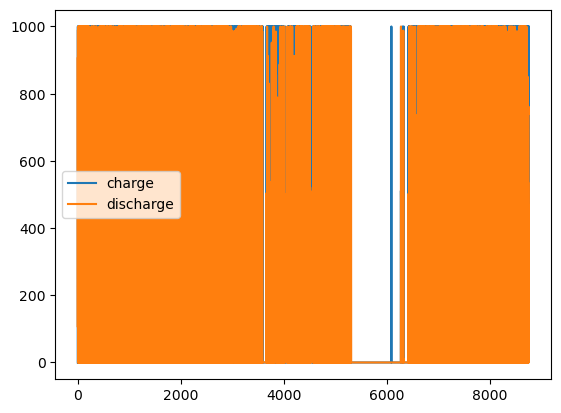

In [81]:
plt.plot(wasserspeicher_charge, label="charge")
plt.plot(wasserspeicher_discharge, label="discharge")
plt.legend()
plt.show()

In [27]:
cap_pv = srcSnkSummary.loc[("PV", "capacity", "[kW_el]")].sum()
cap_bhkw = convSummary.loc[("BHKW", "capacity", "[kW_el]")].sum()
cap_tes = storSummary.loc[("Heizungswasserspeicher", "capacity", "[kW_th*h]")].sum()

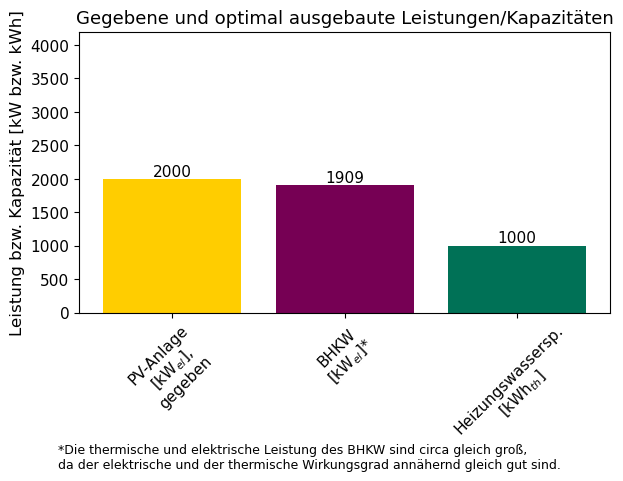

In [28]:
categories = ['PV-Anlage\n[kW$_{el}$],\ngegeben', 'BHKW\n[kW$_{el}$]*', 'Heizungswassersp.\n[kWh$_{th}$]']
capacities = [cap_pv, cap_bhkw, cap_tes]

plt.figure(figsize=(16/2.54, 12/2.54))
bars = plt.bar(categories, capacities, color=[gelb_pv, weinrot_bhkw, grün_tes])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, f'{yval:.0f}', ha='center', va='bottom', fontsize=11)
#plt.xlabel('Technologie', fontsize=12)
plt.ylabel('Leistung bzw. Kapazität [kW bzw. kWh]', fontsize=12)
plt.ylim(0, 4200)
plt.title('Gegebene und optimal ausgebaute Leistungen/Kapazitäten', fontsize=13)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.figtext(0.1, 0.05, '*Die thermische und elektrische Leistung des BHKW sind circa gleich groß,\nda der elektrische und der thermische Wirkungsgrad annähernd gleich gut sind.', ha='left', va='top', fontsize=9)
plt.tight_layout()
#plt.savefig(f"Kapazitäten_weight_co2_{weight_co2}.pdf", bbox_inches='tight')
plt.show()

In [28]:
tac_pv = srcSnkSummary.loc[("PV", "TAC", "[Euro/a]")].sum() # v. a. CAPEX
tac_strom = srcSnkSummary.loc[("Stromkauf von Spotmarkt", "TAC", "[Euro/a]")].sum() # OPEX
tac_gas = srcSnkSummary.loc[("Erdgaskauf", "TAC", "[Euro/a]")].sum() # OPEX
tac_bhkw = convSummary.loc[("BHKW", "TAC", "[Euro/a]")].sum() # OPEX
tac_tes = storSummary.loc[("Heizungswasserspeicher", "TAC", "[Euro/a]")].sum() # v. a. CAPEX
tac_co2 = srcSnkSummary.loc[("CO2 in Atmosphäre", "commodCosts", "[Euro/a]")].sum() # nur OPEX

In [29]:
opex_pv = srcSnkSummary.loc[("PV", "opexCap", "[Euro/a]")].sum()
opex_strom = srcSnkSummary.loc[("Stromkauf von Spotmarkt", "commodCosts", "[Euro/a]")].sum() - srcSnkSummary.loc[("Stromkauf von Spotmarkt", "commodRevenues", "[Euro/a]")].sum()
opex_gas = srcSnkSummary.loc[("Erdgaskauf", "commodCosts", "[Euro/a]")].sum()
opex_bhkw = convSummary.loc[("BHKW", "opexCap", "[Euro/a]")].sum() + convSummary.loc[("BHKW", "opexOp", "[Euro/a]")].sum()
opex_tes = storSummary.loc[("Heizungswasserspeicher", "opexCap", "[Euro/a]")].sum()
opex_co2 = srcSnkSummary.loc[("CO2 in Atmosphäre", "commodCosts", "[Euro/a]")].sum()

In [30]:
capex_pv = srcSnkSummary.loc[("PV", "capexCap", "[Euro/a]")].sum()
capex_strom = 0
capex_gas = 0
capex_bhkw = convSummary.loc[("BHKW", "capexCap", "[Euro/a]")].sum()
capex_tes = storSummary.loc[("Heizungswasserspeicher", "capexCap", "[Euro/a]")].sum()
capex_co2 = 0

In [31]:
# Werte durch 1000 teilen
opex_pv, opex_strom, opex_gas, opex_bhkw, opex_tes, opex_co2 = [x / 1000 for x in [opex_pv, opex_strom, opex_gas, opex_bhkw, opex_tes, opex_co2]]
capex_pv, capex_strom, capex_gas, capex_bhkw, capex_tes, capex_co2 = [x / 1000 for x in [capex_pv, capex_strom, capex_gas, capex_bhkw, capex_tes, capex_co2]]
tac_pv, tac_strom, tac_gas, tac_bhkw, tac_tes, tac_co2 = [x / 1000 for x in [tac_pv, tac_strom, tac_gas, tac_bhkw, tac_tes, tac_co2]]

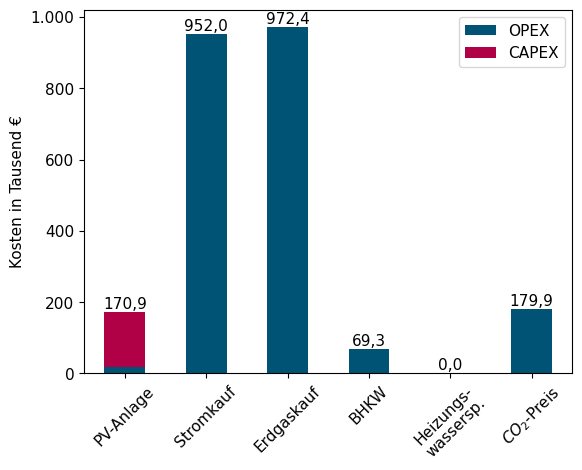

In [ ]:
costs = { # €/Jahr
    'Technologie': ['PV-Anlage', 'Stromkauf', 'Erdgaskauf', 'BHKW', 'Heizungs-\nwassersp.', "$CO_2$-Preis"],
    'OPEX': [opex_pv, opex_strom, opex_gas, opex_bhkw, opex_tes, opex_co2],
    'CAPEX': [capex_pv, capex_strom, capex_gas, capex_bhkw, capex_tes, capex_co2],
    'TAC': [tac_pv, tac_strom, tac_gas, tac_bhkw, tac_tes, tac_co2]
}

df_costs = pd.DataFrame(costs)

def thousand_separator(x, _):
    return f"{x:,.0f}".replace(",", ".")

fig, ax = plt.subplots(figsize=(16/2.54, 12/2.54))
df_costs.set_index('Technologie')[['OPEX', 'CAPEX']].plot(kind='bar', stacked=True, ax=ax, color= [color_strom, color_raumwaerme])

for i, j in enumerate(df_costs['TAC']):
    tac_formatted = f'{j:,.1f}'.replace(',', 'TEMP').replace('.', ',').replace('TEMP', '.')
    ax.text(i, j + 10, tac_formatted, ha='center', fontsize=11) # i is the x-coordinate where the text will be placed, corresponding to the position of the bar. j + 50 is the y-coordinate where the text will be placed, slightly above the top of the bar. f'{j}' is the text that will be displayed, which is the total value from the TAC column.

#plt.xlabel('Technologie', fontsize=12)
ax.set_xlabel("")
plt.ylabel('Kosten in Tausend €', fontsize=11)
#plt.title('OPEX und CAPEX pro Modellkomponente', fontsize=13)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=11)
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousand_separator))  # Y-Achse mit Tausendertrennpunkten
plt.savefig(f"Abb5_22_TAC_StatusQuo.pdf", bbox_inches="tight")
plt.show()

In [36]:
operation_strombedarf = srcSnkSummary.loc[("Strombedarf", "operation", "[kW_el*h/a]")].sum()
operation_heizungswasserbedarf = srcSnkSummary.loc[("Heizungswasserbedarf", "operation", "[kW_th*h/a]")].sum()
operation_pv = srcSnkSummary.loc[("PV", "operation", "[kW_el*h/a]")].sum()
operation_strom = srcSnkSummary.loc[("Stromkauf von Spotmarkt", "operation", "[kW_el*h/a]")].sum()
operation_gas = srcSnkSummary.loc[("Erdgaskauf", "operation", "[kW_CH4,LHV*h/a]")].sum()
operation_bhkw = convSummary.loc[("BHKW", "operation", "[kW_el*h/a]")].sum()
operation_tes = (storSummary.loc[("Heizungswasserspeicher", "operationCharge", "[kW_th*h/a]")].sum() + storSummary.loc[("Heizungswasserspeicher", "operationDischarge", "[kW_th*h/a]")].sum())/2 # Mittelwert

In [37]:
jahressummen = [x / 1000000 for x in [operation_pv, operation_strom, operation_gas, operation_bhkw, operation_tes]]
jahresbedarfe = [x / 1000000 for x in [operation_strombedarf, operation_heizungswasserbedarf]]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15008\736477758.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


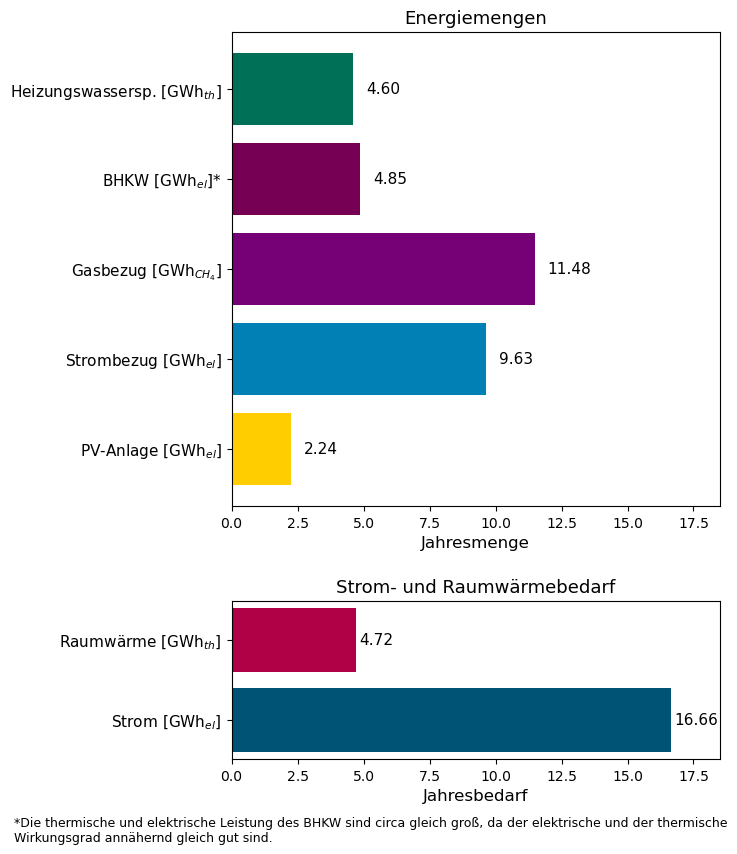

In [38]:
categories2 = ['PV-Anlage [GWh$_{el}$]', "Strombezug [GWh$_{el}$]", "Gasbezug [GWh$_{CH_4}$]", 'BHKW [GWh$_{el}$]*', 'Heizungswassersp. [GWh$_{th}$]']
categories3 = ['Strom [GWh$_{el}$]', 'Raumwärme [GWh$_{th}$]']

fig = plt.figure(figsize=(16/2.54, 24/2.54))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.3)

# Erstes Diagramm
ax1 = plt.subplot(gs[0])
bars1 = ax1.barh(categories2, jahressummen, color=[gelb_pv, blau_stromkauf, lila_gas, weinrot_bhkw, grün_tes])
for bar in bars1:
    xval = bar.get_width()
    ax1.text(xval + 0.5, bar.get_y() + bar.get_height() / 2, f'{xval:.2f}', ha='left', va='center', fontsize=11)
ax1.set_xlabel('Jahresmenge', fontsize=12)
ax1.set_title('Energiemengen', fontsize=13)
ax1.set_yticks(ax1.get_yticks())
ax1.set_yticklabels(categories2, rotation=0, fontsize=11)

# Zweites Diagramm
ax2 = plt.subplot(gs[1])
bars2 = ax2.barh(categories3, jahresbedarfe, color=[color_strom, color_raumwaerme])
for bar in bars2:
    xval = bar.get_width()
    ax2.text(xval + 0.1, bar.get_y() + bar.get_height() / 2, f'{xval:.2f}', ha='left', va='center', fontsize=11)
ax2.set_xlabel('Jahresbedarf', fontsize=12)
ax2.set_title('Strom- und Raumwärmebedarf', fontsize=13)
ax2.set_yticks(ax2.get_yticks())
ax2.set_yticklabels(categories3, rotation=0, fontsize=11)

max_x = max(ax1.get_xlim()[1], ax2.get_xlim()[1])
ax1.set_xlim(0, max_x+1)
ax2.set_xlim(0, max_x+1)

plt.figtext(-0.22, 0.05, '*Die thermische und elektrische Leistung des BHKW sind circa gleich groß, da der elektrische und der thermische\nWirkungsgrad annähernd gleich gut sind.', ha='left', va='top', fontsize=9)

plt.tight_layout()
#plt.savefig(f"operation_weight_co2_{weight_co2}.pdf", bbox_inches="tight")
plt.show()

## 9.2 Vis. für MA

In [4]:
data_status_quo = {
    "Szenario": [
        "Status Quo", "Strompreis sinkt", "Gaspreis sinkt", 
        "CAPEX WP sinkt", "CAPEX LIB sinkt", "Strompreis schwankt", 
        "CO2-Intensität Strom sinkt", "PV-Anlagenverdopplung", "Strompreis steigt"
    ],
    "TAC [T€]": [
        2345, 1913, 1758, None, None, 2330, 2250, 2345, 2741
    ],
    "TAC ohne Überschussstrom [T€]": [
        2345, 1913, 1758, None, None, 2325, 2250, 2345, 2735
    ],
    "CO2-Emissionen [t]": [
        5996, 5994, 5996, None, None, 6117, 2833, 5948, 6007
    ]
}
df_status_quo = pd.DataFrame(data_status_quo)
df_status_quo


,Szenario,TAC [T€],TAC ohne Überschussstrom [T€],CO2-Emissionen [t]
0,Status Quo,2345.0,2345.0,5996.0
1,Strompreis sinkt,1913.0,1913.0,5994.0
2,Gaspreis sinkt,1758.0,1758.0,5996.0
3,CAPEX WP sinkt,NaN,NaN,NaN
4,CAPEX LIB sinkt,NaN,NaN,NaN
5,Strompreis schwankt,2330.0,2325.0,6117.0
6,CO2-Intensität Strom sinkt,2250.0,2250.0,2833.0
7,PV-Anlagenverdopplung,2345.0,2345.0,5948.0
8,Strompreis steigt,2741.0,2735.0,6007.0


In [33]:
# Liste der Unterordner
ordner = [
    "Auswertung Strompreis steigt",
    "Auswertung Strompreis sinkt",
    "Auswertung Strompreis schwankt stärker",
    "Auswertung Wärmepumpe",
    "Auswertung LIB",
    "Auswertung Gas",
    "Auswertung Stromintensität",
    "Auswertung PV-Verdopplung",
    "Auswertung Basisszenario"
]

abkuerzungen = [
    "Strompreis\nsteigt",  # Strompreis steigt
    "Strompreis sinkt",   # Strompreis sinkt
    "Strompreis\nschwankt",  # Strompreis schwankt stärker
    "CAPEX WP\nsinkt",  # Wärmepumpe
    "CAPEX LIB\nsinkt",  # Lithium-Ionen-Batterie
    "Gaspreis sinkt",  # Gas
    "CO$_2$-Intensität\nStrom sinkt",  # Stromintensität
    "PV-Anlagen-\nverdopplung", # PV-Verdopplung
    "Basis-\nszenario" # Basisszenario
]

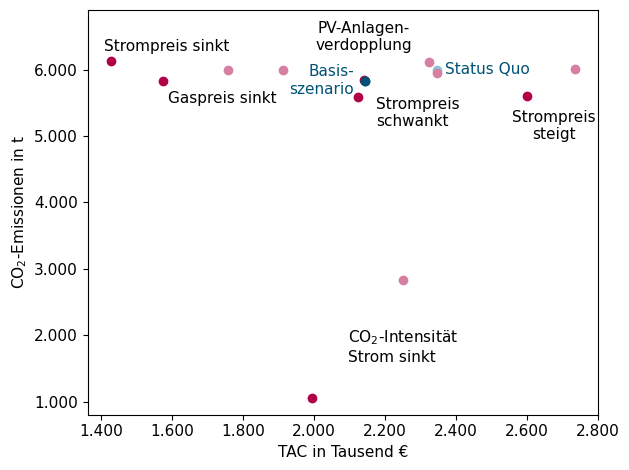

In [ ]:
tac_values_zsmfssg = []
co2_values_zsmfssg = []
labels_zsmfssg = []
colors_zsmfssg = []

def thousand_separator(x, _):
    return f"{x:,.0f}".replace(",", ".")

for ordner_name, abkuerzung in zip(ordner, abkuerzungen):
    dateipfad = cwd / ordner_name / "Paretofront.csv"

    if abkuerzung in ["CAPEX LIB\nsinkt", "CAPEX WP\nsinkt"]:
        continue
    
    if dateipfad.exists():
        df = pd.read_csv(dateipfad)
        
        df_filtered = df[df["Weight CO2"] == 0.0]
        
        tac_values_zsmfssg = df_filtered["TAC [€]"].values / 1000  # TAC in Tausend Euro
        co2_values_zsmfssg = df_filtered["CO2 Emissions [g]"].values / 1e6  # CO2 in Tonnen
        
        if abkuerzung == "Basis-\nszenario":
            colors_zsmfssg = color_strom
        else:
            colors_zsmfssg = color_raumwaerme
        
        plt.plot(tac_values_zsmfssg, co2_values_zsmfssg, color=colors_zsmfssg, label=abkuerzung, linestyle='-', linewidth=1.5, marker='o')
        
        if abkuerzung == "PV-Anlagen-\nverdopplung":
            plt.text(tac_values_zsmfssg[0], co2_values_zsmfssg[0] + 400, abkuerzung, fontsize=11, ha='center', va='bottom')
        elif abkuerzung == "CAPEX WP\nsinkt":
            plt.text(tac_values_zsmfssg[0] - 15, co2_values_zsmfssg[0], abkuerzung, fontsize=11, ha='right', va='bottom')
        elif abkuerzung == "CAPEX LIB\nsinkt":
            plt.text(tac_values_zsmfssg[0] + 15, co2_values_zsmfssg[0] - 180, abkuerzung, fontsize=11, ha='left', va='top')
        elif abkuerzung == "Strompreis\nschwankt":
            plt.text(tac_values_zsmfssg[0] + 50, co2_values_zsmfssg[0], abkuerzung, fontsize=11, ha="left", va="top")
        elif abkuerzung == "Strompreis sinkt":
            plt.text(tac_values_zsmfssg[0] - 20, co2_values_zsmfssg[0] + 100, abkuerzung, fontsize=11, ha="left", va="bottom")
        elif abkuerzung == "Gaspreis sinkt":
            plt.text(tac_values_zsmfssg[0] + 15, co2_values_zsmfssg[0] - 150, abkuerzung, fontsize=11, ha="left", va="top")
        elif abkuerzung == "CO$_2$-Intensität\nStrom sinkt":
            plt.text(tac_values_zsmfssg[0] + 100, co2_values_zsmfssg[0] + 500, abkuerzung, fontsize=11, ha="left", va="bottom")
        elif abkuerzung == "Strompreis\nsteigt":
            plt.text(tac_values_zsmfssg[0] + 75, co2_values_zsmfssg[0] - 200, abkuerzung, fontsize=11, ha="center", va="top")
        else:
            # Basisszenario
            plt.text(tac_values_zsmfssg[0] - 30, co2_values_zsmfssg[0], abkuerzung, fontsize=11, ha='right', va='center', color=color_strom)

for i, row in df_status_quo.iterrows():
    tac_value = row["TAC ohne Überschussstrom [T€]"]
    co2_value = row["CO2-Emissionen [t]"]
    label = row["Szenario"]
    
    colorsq = color_strom_light if label == "Status Quo" else color_raumwaerme_light

    if pd.notna(tac_value) and pd.notna(co2_value):
        plt.scatter(tac_value, co2_value, color=colorsq)
        if label == "Status Quo":
            plt.text(tac_value + 25, co2_value, label, fontsize=11, ha='left', va='center', color=color_strom)

plt.gca().xaxis.set_major_formatter(FuncFormatter(thousand_separator))
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousand_separator))

plt.xlabel('TAC in Tausend €', fontsize=11)
plt.ylabel('CO$_2$-Emissionen in t', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.ylim(None, 6900)
plt.tight_layout()
plt.savefig(f"Abb5_21_Zsmfssg_Status Quo.svg")
plt.show()


# 10.1 Manuelle Berechnung

für PV-Sensi tac_pv verdoppeln

In [117]:
tac_pv = 170.9 * 1000 # opexPerCapacity und capexPerCapacity
tac_bhkw = 31.84 * 1000 # opexPerCapacity
erdgasbezug = heizungswasserverb/0.4113
netzstrombezug = stromverbr - pv*2000 - erdgasbezug*0.4225
print(netzstrombezug.sum())
netzstrombezug = np.clip(netzstrombezug, 0, None) # Annahme, dass entweder PV abgeregelt wird oder BHKW-Strom eingespeist werden würde an Regelenergiemarkt
print(netzstrombezug.sum())
tac_gas = (erdgasbezug*gaspreis).sum()
tac_strom = (netzstrombezug*(df_strom_pr_em_2023_sensi["Strompreis"]/1000)).sum() # €/MWh in €/kWh
tac_bhkw += (0.008 * erdgasbezug*0.4225).sum() # mit opexPerOperation
tac_tes=0


co2_faktor_gas=200.8
co2_gas = co2_faktor_gas * erdgasbezug
co2_strom = stromemissionen* netzstrombezug # g
co2_total = (co2_strom + co2_gas).sum()/(1000*1000) # t

tac_co2 = co2_total*30

tac_total = tac_pv + tac_bhkw + tac_gas + tac_strom + tac_co2 # in €
tac_total = tac_total/1000 # T€

print(f"CO2: {co2_total.sum()}")
print(f"TAC: {tac_total.sum()}")

9574441.869228868
9940716.592338724
CO2: 2851.955357614264
TAC: 2310.04107400518


In [118]:
# Werte durch 1000 teilen
tac_pv, tac_strom, tac_gas, tac_bhkw, tac_tes, tac_co2 = [x / 1000 for x in [tac_pv, tac_strom, tac_gas, tac_bhkw, tac_tes, tac_co2]]

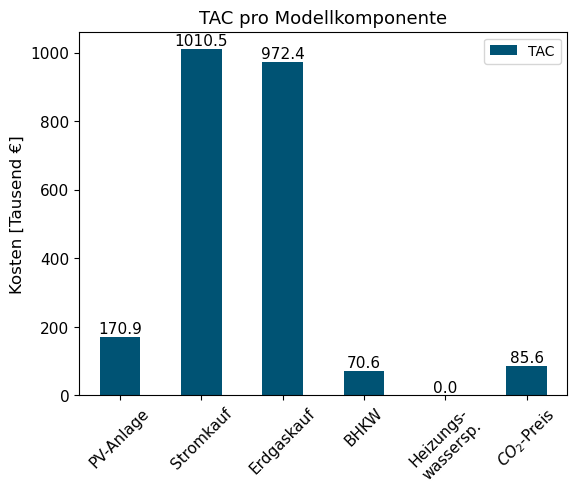

In [ ]:
costs = { # €/Jahr
    'Technologie': ['PV-Anlage', 'Stromkauf', 'Erdgaskauf', 'BHKW', 'Heizungs-\nwassersp.', "$CO_2$-Preis"],
    'TAC': [tac_pv, tac_strom, tac_gas, tac_bhkw, tac_tes, tac_co2]
}

df_costs = pd.DataFrame(costs)

def thousand_separator(x, _):
    return f"{x:,.0f}".replace(",", ".")

fig, ax = plt.subplots(figsize=(16/2.54, 12/2.54))
df_costs.set_index('Technologie')[['TAC']].plot(kind='bar', stacked=True, ax=ax, color= [color_strom, color_raumwaerme])

for i, j in enumerate(df_costs['TAC']):
    tac_formatted = f'{j:,.1f}'.replace(',', 'TEMP').replace('.', ',').replace('TEMP', '.')
    ax.text(i, j + 10, tac_formatted, ha='center', fontsize=11) # i is the x-coordinate where the text will be placed, corresponding to the position of the bar. j + 50 is the y-coordinate where the text will be placed, slightly above the top of the bar. f'{j}' is the text that will be displayed, which is the total value from the TAC column.

#plt.xlabel('Technologie', fontsize=12)
ax.set_xlabel("")
plt.ylabel('Kosten [Tausend €]', fontsize=12)
plt.title('TAC pro Modellkomponente', fontsize=13)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousand_separator))  # Y-Achse mit Tausendertrennpunkten
#plt.savefig(f"Kosten_weight_co2_{weight_co2}.pdf", bbox_inches="tight")
plt.show()